In [1]:
!pip install tqdm tensorflow_docs mtcnn imutils imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00


In [2]:
base_dir = "/kaggle/input/mini-face-forensics/FF++/"

In [3]:
import os
import pandas as pd
import cv2 as cv
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from mtcnn import MTCNN
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import imageio

In [4]:
label_types = os.listdir('/kaggle/input/mini-face-forensics/FF++')
print (label_types)

['fake', 'real']


In [4]:
detector = MTCNN()

In [5]:
# Example data
video_paths = []
labels = []  


for sub_folder in os.listdir(base_dir):
    label = sub_folder
    
    sub_folder = os.path.join(base_dir, sub_folder)
    
    for vid in os.listdir(sub_folder):
        video_paths.append(os.path.join(sub_folder, vid))
        labels.append(label)

In [6]:
# Print the first 10 and last 10 elements of video_paths
print("First 10 video paths:", video_paths[:10])
print("Last 10 video paths:", video_paths[-10:])

# Print the first 10 and last 10 elements of labels
print("First 10 labels:", labels[:10])
print("Last 10 labels:", labels[-10:])

First 10 video paths: ['/kaggle/input/mini-face-forensics/FF++/fake/02_13__exit_phone_room__CP5HFV3K.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/03_14__talking_against_wall__ZC2KYASW.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/03_15__outside_talking_pan_laughing__Y11NT1YX.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_26__walking_down_street_outside_angry__FGNGC2GT.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_03__hugging_happy__7NGMD8FT.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_09__walk_down_hall_angry__N9CWME71.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/01_12__outside_talking_pan_laughing__TNI7KUZ6.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_03__podium_speech_happy__6PHZRQ4H.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_02__walking_down_street_outside_angry__O4SXNLRL.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/08_05__walk_down_hall_angry__FBICSP2C.mp4']
Last 10 video paths: ['/kaggle/input/mini-face-forensics/F

In [7]:
# Preparing the data
df = pd.DataFrame({'video_path': video_paths, 'label': labels})

In [8]:
print(df.head())
print(df.tail())

                                          video_path label
0  /kaggle/input/mini-face-forensics/FF++/fake/02...  fake
1  /kaggle/input/mini-face-forensics/FF++/fake/03...  fake
2  /kaggle/input/mini-face-forensics/FF++/fake/03...  fake
3  /kaggle/input/mini-face-forensics/FF++/fake/07...  fake
4  /kaggle/input/mini-face-forensics/FF++/fake/07...  fake
                                            video_path label
395  /kaggle/input/mini-face-forensics/FF++/real/13...  real
396  /kaggle/input/mini-face-forensics/FF++/real/06...  real
397  /kaggle/input/mini-face-forensics/FF++/real/02...  real
398  /kaggle/input/mini-face-forensics/FF++/real/04...  real
399  /kaggle/input/mini-face-forensics/FF++/real/12...  real


In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [10]:
print(train_df.head())
print(train_df.tail())

                                            video_path label
3    /kaggle/input/mini-face-forensics/FF++/fake/07...  fake
18   /kaggle/input/mini-face-forensics/FF++/fake/02...  fake
202  /kaggle/input/mini-face-forensics/FF++/real/08...  real
250  /kaggle/input/mini-face-forensics/FF++/real/14...  real
274  /kaggle/input/mini-face-forensics/FF++/real/13...  real
                                            video_path label
71   /kaggle/input/mini-face-forensics/FF++/fake/03...  fake
106  /kaggle/input/mini-face-forensics/FF++/fake/01...  fake
270  /kaggle/input/mini-face-forensics/FF++/real/11...  real
348  /kaggle/input/mini-face-forensics/FF++/real/11...  real
102  /kaggle/input/mini-face-forensics/FF++/fake/02...  fake


In [14]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")


train_df.sample(10)

Total videos for training: 320
Total videos for testing: 80


,video_path,label
228,/kaggle/input/mini-face-forensics/FF++/real/15...,real
23,/kaggle/input/mini-face-forensics/FF++/fake/07...,fake
34,/kaggle/input/mini-face-forensics/FF++/fake/03...,fake
207,/kaggle/input/mini-face-forensics/FF++/real/02...,real
368,/kaggle/input/mini-face-forensics/FF++/real/09...,real
317,/kaggle/input/mini-face-forensics/FF++/real/04...,real
239,/kaggle/input/mini-face-forensics/FF++/real/01...,real
170,/kaggle/input/mini-face-forensics/FF++/fake/03...,fake
215,/kaggle/input/mini-face-forensics/FF++/real/16...,real
358,/kaggle/input/mini-face-forensics/FF++/real/10...,real


## 1) Run Face Detection Only Once for the First Frame

In [15]:
def get_face_region_first_frame(frame, previous_box=None):
    if previous_box is None:
        # Detect the face only if no previous bounding box is provided
        detections = detector.detect_faces(frame)
        if detections:
            x, y, width, height = detections[0]['box']
            previous_box = (x, y, width, height)
        else:
            return crop_center_square(frame), None  # fallback to center crop if no face detected
    else:
        x, y, width, height = previous_box

    face_region = frame[y:y+height, x:x+width]
    return face_region, previous_box

In [16]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [17]:
IMG_SIZE = 224

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE), skip_frames=2):
    cap = cv.VideoCapture(path)
    frames = []
    frame_count = 0
    previous_box = None  # Store the bounding box from the first frame

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Process frames as per skip rate
            if frame_count % skip_frames == 0:
                frame, previous_box = get_face_region_first_frame(frame, previous_box)
                frame = cv.resize(frame, resize)
                frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
                frames.append(frame)

                if len(frames) == max_frames:
                    break
            frame_count += 1

        # Pad with the last frame if we have fewer frames than max_frames
        while len(frames) < max_frames and frames:
            frames.append(frames[-1])

    finally:
        cap.release()

    return np.array(frames)

## Feature extraction

In [18]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["label"]))
print(label_processor.get_vocabulary())

labels = train_df["label"].values
labels = label_processor(labels[..., None]).numpy()
labels

['fake', 'real']


array([[0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Create the StringLookup layer
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["label"]))
print(label_processor.get_vocabulary())

# Save the vocabulary as a file
np.save('label_processor_vocabulary.npy', label_processor.get_vocabulary())


['fake', 'real']


In [13]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [14]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import tensorflow as tf
from tqdm import tqdm

# Suppress TensorFlow and Keras logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["video_path"].values.tolist()
    
    labels = df["label"].values
    labels = label_processor(labels[..., None]).numpy()

    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for idx, path in enumerate(tqdm(video_paths, desc="Processing Videos", unit="video")):
        frames = load_video(path)
        frames = frames[None, ...]

        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0  # Disable prediction logs
                )
            temp_frame_mask[i, :length] = 1

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

train_data, train_labels = prepare_all_videos(train_df)
test_data, test_labels = prepare_all_videos(test_df)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")



print(f"train_labels in train set: {train_labels.shape}")

print(f"test_labels in train set: {test_labels.shape}")

# MAX_SEQ_LENGTH = 20, NUM_FEATURES = 2048. We have defined this above under hyper parameters

Processing Videos: 100%|██████████| 80/80 [08:56<00:00,  6.70s/video]

Frame features in train set: (320, 20, 2048)
Frame masks in train set: (320, 20)
train_labels in train set: (320, 1)
test_labels in train set: (80, 1)


In [23]:
import numpy as np
import os

# Directory to save processed data
save_dir = '/kaggle/working/processed_data/'

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

def save_data(data, labels, data_type):
    # Save features and masks
    features_path = os.path.join(save_dir, f"{data_type}_features.npy")
    masks_path = os.path.join(save_dir, f"{data_type}_masks.npy")
    labels_path = os.path.join(save_dir, f"{data_type}_labels.npy")
    
    np.save(features_path, data[0])
    np.save(masks_path, data[1])
    np.save(labels_path, labels)
    
    print(f"Data saved to {save_dir}")

# Save the train and test data
save_data(train_data, train_labels, "train")
save_data(test_data, test_labels, "test")


Data saved to /kaggle/working/processed_data/
Data saved to /kaggle/working/processed_data/


In [35]:
import numpy as np

def load_data(data_type):
    features_path = f'/kaggle/working/processed_data/{data_type}_features.npy'
    masks_path = f'/kaggle/working/processed_data/{data_type}_masks.npy'
    labels_path = f'/kaggle/working/processed_data/{data_type}_labels.npy'
    
    features = np.load(features_path)
    masks = np.load(masks_path)
    labels = np.load(labels_path)
    
    print(f"Loaded {data_type} data.")
    return (features, masks), labels

# Load the train and test data
train_data, train_labels = load_data("train")
test_data, test_labels = load_data("test")

print(f"Loaded train data shape: {train_data[0].shape}")
print(f"Loaded train labels shape: {train_labels.shape}")


Loaded train data.
Loaded test data.
Loaded train data shape: (320, 20, 2048)
Loaded train labels shape: (320, 1)


In [77]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

EPOCHS = 20
# Utility for running experiments.
def run_experiment():
    filepath = "/kaggle/working/tmp/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/20
1/7 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6562 - loss: 0.6763
Epoch 1: val_loss improved from inf to 0.69373, saving model to /kaggle/working/tmp/video_classifier.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5146 - loss: 0.6937 - val_accuracy: 0.4583 - val_loss: 0.6937
Epoch 2/20
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4375 - loss: 0.7306
Epoch 2: val_loss improved from 0.69373 to 0.69366, saving model to /kaggle/working/tmp/video_classifier.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4408 - loss: 0.7097 - val_accuracy: 0.4688 - val_loss: 0.6937
Epoch 3/20
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5938 - loss: 0.6747
Epoch 3: val_loss improved from 0.69366 to 0.69280, saving model to /kaggle/working/tmp/video_classifier.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5906 - loss: 0.6834 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 4/20
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5938

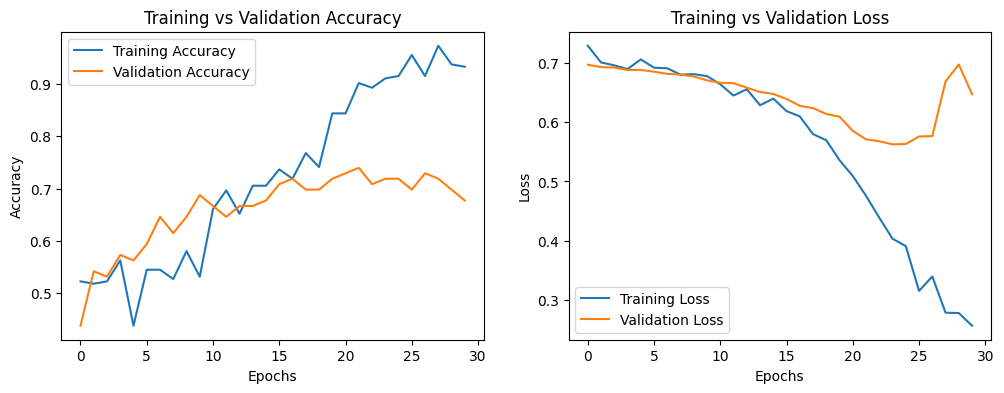

In [78]:
import matplotlib.pyplot as plt


# Extract training and validation accuracy & loss
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


In [79]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test set
test_predictions = sequence_model.predict([test_data[0], test_data[1]])

# Since you used sparse categorical cross-entropy, the predictions will be in the form of class indices.
# Convert them to class labels
predicted_labels = np.argmax(test_predictions, axis=-1)

# Print classification report
print(classification_report(test_labels, predicted_labels))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        44
           1       0.76      0.86      0.81        36

    accuracy                           0.81        80
   macro avg       0.81      0.82      0.81        80
weighted avg       0.82      0.81      0.81        80



In [80]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Make predictions on the test set
test_predictions = sequence_model.predict([test_data[0], test_data[1]])

# Since you used sparse categorical cross-entropy, the predictions will be in the form of class indices.
# Convert them to class labels
predicted_labels = np.argmax(test_predictions, axis=-1)

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

# Generate and print confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        44
           1       0.76      0.86      0.81        36

    accuracy                           0.81        80
   macro avg       0.81      0.82      0.81        80
weighted avg       0.82      0.81      0.81        80

Confusion Matrix:
[[34 10]
 [ 5 31]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        44
           1       0.76      0.86      0.81        36

    accuracy                           0.81        80
   macro avg       0.81      0.82      0.81        80
weighted avg       0.82      0.81      0.81        80



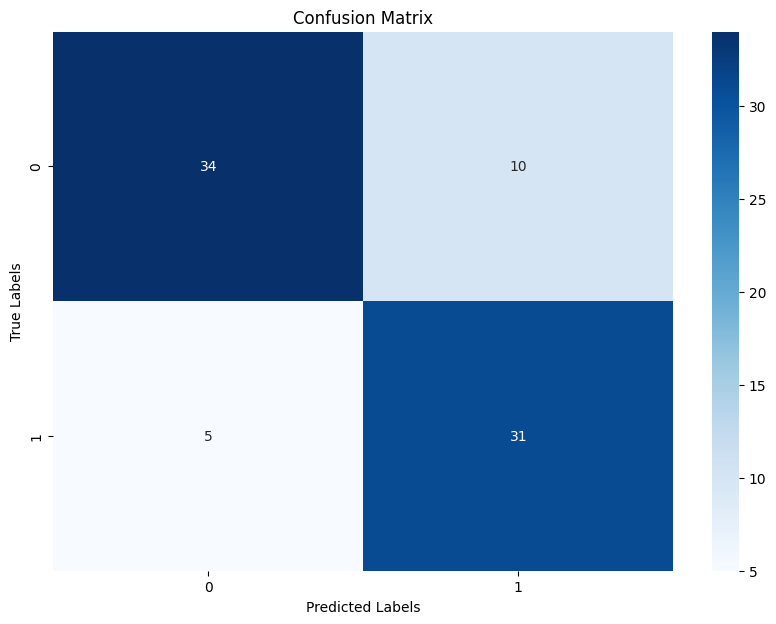

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions on the test set
test_predictions = sequence_model.predict([test_data[0], test_data[1]])

# Since you used sparse categorical cross-entropy, the predictions will be in the form of class indices.
# Convert them to class labels
predicted_labels = np.argmax(test_predictions, axis=-1)

# Print classification report
print(classification_report(test_labels, predicted_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

        Real       0.87      0.77      0.82        44
    Deepfake       0.76      0.86      0.81        36

    accuracy                           0.81        80
   macro avg       0.81      0.82      0.81        80
weighted avg       0.82      0.81      0.81        80



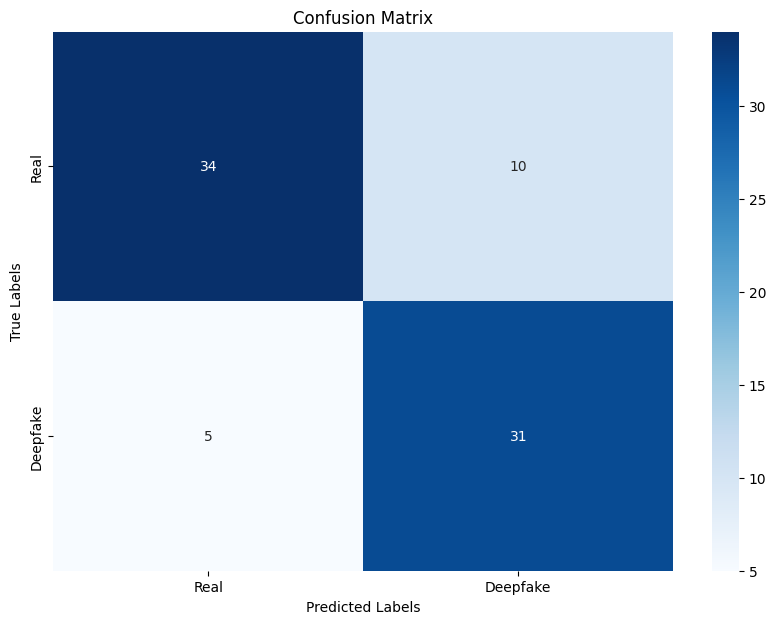

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions on the test set
test_predictions = sequence_model.predict([test_data[0], test_data[1]])

# Convert predicted probabilities to class labels (0 = Real, 1 = Deepfake)
predicted_labels = np.argmax(test_predictions, axis=-1)

# Print classification report
print("Classification Report:\n", classification_report(test_labels, predicted_labels, target_names=["Real", "Deepfake"]))

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Define class names
class_names = ["Real", "Deepfake"]

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Testing

In [29]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

test_video = np.random.choice(test_df["video_path"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)

Test video path: /kaggle/input/mini-face-forensics/FF++/real/11__kitchen_still.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
  real: 93.60%
  fake:  6.40%


In [35]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


# Update the sequence_prediction function to predict on the given video paths
def sequence_prediction(video_path):
    class_vocab = label_processor.get_vocabulary()

    # Load the video based on the path passed as input
    frames = load_video(video_path)
    frame_features, frame_mask = prepare_single_video(frames)
    
    # Predict using the sequence model
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    # Output the prediction probabilities for each class
    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    return frames

# Test prediction on real and fake sample videos
real_sample_path = "/kaggle/input/deepfake-testing-videos/model1.mp4"
fake_sample_path = "/kaggle/input/deepfake-testing-videos/modeloutput1.mp4"

print("Predicting on the real sample video:")
test_frames_real = sequence_prediction(real_sample_path)

print("\nPredicting on the fake sample video:")
test_frames_fake = sequence_prediction(fake_sample_path)


Predicting on the real sample video:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
  real: 57.66%
  fake: 42.34%

Predicting on the fake sample video:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [36]:
# Load the vocabulary
vocabulary2 = np.load('label_processor_vocabulary.npy', allow_pickle=True)

# Recreate the StringLookup layer using the loaded vocabulary
label_processor2 = keras.layers.StringLookup(num_oov_indices=0, vocabulary=vocabulary2.tolist())
print(label_processor2.get_vocabulary())


['fake', 'real']


In [42]:
# Save the entire model
sequence_model.save("/kaggle/working/deepfake_video.h5")


In [43]:
import keras
import numpy as np

# Load the full model (architecture + weights)
deepfake_model = keras.models.load_model('/kaggle/working/deepfake_video.h5')

# Assuming 'feature_extractor' and 'label_processor' are defined earlier in your script
# and they are capable of extracting features and processing labels respectively.

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(video_path):
    class_vocab = label_processor2.get_vocabulary()

    # Load the video frames from the given path
    frames = load_video(video_path)
    frame_features, frame_mask = prepare_single_video(frames)
    
    # Predict using the loaded deepfake model
    probabilities = deepfake_model.predict([frame_features, frame_mask])[0]

    # Output the prediction probabilities for each class
    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    return frames

# Test prediction on real and fake sample videos
real_sample_path = "/kaggle/input/deepfake-testing-videos/model1.mp4"
fake_sample_path = "/kaggle/input/deepfake-testing-videos/modeloutput1.mp4"

print("Predicting on the real sample video:")
test_frames_real = sequence_prediction(real_sample_path)

print("\nPredicting on the fake sample video:")
test_frames_fake = sequence_prediction(fake_sample_path)


Predicting on the real sample video:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
  real: 57.66%
  fake: 42.34%

Predicting on the fake sample video:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━

In [ ]:
# Load the vocabulary
vocabulary2 = np.load('label_processor_vocabulary.npy', allow_pickle=True)

# Recreate the StringLookup layer using the loaded vocabulary
label_processor2 = keras.layers.StringLookup(num_oov_indices=0, vocabulary=vocabulary2.tolist())
print(label_processor2.get_vocabulary())


Complete Predicition Processing Pipeline and Prediction From Saved Model(architecture + weights) and Processed Labels From Training

In [ ]:
!pip install tqdm tensorflow_docs mtcnn imutils imageio

In [ ]:
import os
import pandas as pd
import cv2 as cv
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from mtcnn import MTCNN
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import imageio

In [44]:
import keras
import numpy as np
import cv2 as cv
detector = MTCNN()

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

# Load the full model (architecture + weights)
deepfake_model = keras.models.load_model('/kaggle/working/deepfake_video.h5')

# Load the vocabulary
vocabulary2 = np.load('label_processor_vocabulary.npy', allow_pickle=True)

# Recreate the StringLookup layer using the loaded vocabulary
label_processor2 = keras.layers.StringLookup(num_oov_indices=0, vocabulary=vocabulary2.tolist())

# Feature extractor function
def build_feature_extractor2():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

# Instantiate the feature extractor
feature_extractor1 = build_feature_extractor2()

# Prepare video frames for feature extraction
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor1.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

# Sequence prediction using the model
def sequence_prediction(video_path):
    class_vocab = label_processor2.get_vocabulary()

    # Load the video frames from the given path (you will need to implement this function)
    frames = load_video(video_path)
    frame_features, frame_mask = prepare_single_video(frames)
    
    # Predict using the loaded deepfake model
    probabilities = deepfake_model.predict([frame_features, frame_mask])[0]

    # Output the prediction probabilities for each class
    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    return frames

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE), skip_frames=2):
    cap = cv.VideoCapture(path)
    frames = []
    frame_count = 0
    previous_box = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % skip_frames == 0:
            frame, previous_box = get_face_region_first_frame(frame, previous_box)
            frame = cv.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
            frames.append(frame)

            if len(frames) == max_frames:
                break
        frame_count += 1

    while len(frames) < max_frames and frames:
        frames.append(frames[-1])

    cap.release()
    return np.array(frames)

# Face region extraction
def get_face_region_first_frame(frame, previous_box=None):
    if previous_box is None:
        # Detect the face only if no previous bounding box is provided
        detections = detector.detect_faces(frame)
        if detections:
            x, y, width, height = detections[0]['box']
            previous_box = (x, y, width, height)
        else:
            return crop_center_square(frame), None  # fallback to center crop if no face detected
    else:
        x, y, width, height = previous_box

    face_region = frame[y:y+height, x:x+width]
    return face_region, previous_box

# Test prediction on real and fake sample videos
real_sample_path = "/kaggle/input/deepfake-testing-videos/model1.mp4"
fake_sample_path = "/kaggle/input/deepfake-testing-videos/modeloutput1.mp4"

print("Predicting on the real sample video:")
test_frames_real = sequence_prediction(real_sample_path)

print("\nPredicting on the fake sample video:")
test_frames_fake = sequence_prediction(fake_sample_path)


Predicting on the real sample video:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
  real: 57.66%
  fake: 42.34%

Predicting on the fake sample video:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━